Volem predir buyer_d7 (si compra o no) y iap_revenue_d7 (quants diners gasta)

In [1]:
import dask
import dask.dataframe as dd

dask.config.set({"dataframe.convert-string": False})

dataset_path = "./smadex-challenge-predict-the-revenue/train/train"
filters = [("datetime", ">=", "2025-10-06-00-00"), ("datetime", "<", "2025-10-06-01-00")]

ddf = dd.read_parquet(
    dataset_path,
    filters=filters
)

In [2]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de desbalanceo
buyer_counts = ddf['buyer_d7'].value_counts().compute()
print(f"Distribución buyer_d7:\n{buyer_counts}")
print(f"Ratio: {buyer_counts[0]/buyer_counts[1]:.2f}:1")

# Análisis de revenue
buyers = ddf[ddf['buyer_d7'] == 1]['iap_revenue_d7'].compute()
print(f"\nEstadísticas revenue (solo compradores):")
print(f"Mean: {buyers.mean():.2f}")
print(f"Median: {buyers.median():.2f}")
print(f"P25: {buyers.quantile(0.25):.2f}")
print(f"P75: {buyers.quantile(0.75):.2f}")
print(f"P90: {buyers.quantile(0.90):.2f}")

Distribución buyer_d7:
buyer_d7
0    119541
1      5129
Name: count, dtype: int64
Ratio: 23.31:1

Estadísticas revenue (solo compradores):
Mean: 22.34
Median: 6.89
P25: 1.99
P75: 16.59
P90: 40.00


In [3]:
# Análisis exploratorio completo
import pandas as pd
# 1. Ver columnas disponibles y tipos de datos
print("=" * 50)
print("INFORMACIÓN DEL DATASET")
print("=" * 50)
cols = ddf.columns.tolist()
print(f"Columnas: {cols}")
print(f"\nTipos de datos:")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(ddf.dtypes)
print(f"\nShape: {ddf.shape[0].compute()} filas")


INFORMACIÓN DEL DATASET
Columnas: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'release_date', 'release_msrp', 'weekday', 'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'city_hist', 'country_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'dev_language_hist', 'dev_osv_hist', 'first_request_ts', 'first_request_ts_bundle', 'first_request_ts_category_bottom_taxonomy', 'hour_ratio', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'iap_revenue_usd_category_botto

In [4]:

# 2. Análisis de valores nulos
print("\n" + "=" * 50)
print("VALORES NULOS")
print("=" * 50)
null_counts = ddf.isnull().sum().compute()
print(null_counts[null_counts > 0])



VALORES NULOS
registration                                   64703
retention_d1_to_d7                             11662
retention_d3_to_d7                             11662
retention_d7_to_d14                            11662
retention_d1                                   11662
retention_d3                                   11662
retentiond7                                    11662
advertiser_category                            11453
advertiser_subcategory                         11453
advertiser_bottom_taxonomy_level               49879
carrier                                        92864
country                                           38
region                                         93763
dev_make                                        2252
dev_model                                        350
dev_osv                                          861
release_date                                     589
release_msrp                                   13167
avg_act_days                   

In [5]:

# 3. Distribución de revenue en compradores (más detallada)
print("\n" + "=" * 50)
print("DISTRIBUCIÓN REVENUE (SOLO COMPRADORES)")
print("=" * 50)
buyers_revenue = ddf[ddf['buyer_d7'] == 1]['iap_revenue_d7'].compute()
print(f"Count: {len(buyers_revenue)}")
print(f"Min: ${buyers_revenue.min():.2f}")
print(f"P10: ${buyers_revenue.quantile(0.10):.2f}")
print(f"P25: ${buyers_revenue.quantile(0.25):.2f}")
print(f"P50 (Median): ${buyers_revenue.quantile(0.50):.2f}")
print(f"Mean: ${buyers_revenue.mean():.2f}")
print(f"P75: ${buyers_revenue.quantile(0.75):.2f}")
print(f"P90: ${buyers_revenue.quantile(0.90):.2f}")
print(f"P95: ${buyers_revenue.quantile(0.95):.2f}")
print(f"P99: ${buyers_revenue.quantile(0.99):.2f}")
print(f"Max: ${buyers_revenue.max():.2f}")



DISTRIBUCIÓN REVENUE (SOLO COMPRADORES)
Count: 5129
Min: $0.00
P10: $0.00
P25: $1.99
P50 (Median): $6.89
Mean: $22.34
P75: $16.59
P90: $40.00
P95: $70.31
P99: $227.14
Max: $3201.20


In [6]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


# 4. Identificar posibles features predictivas
print("\n" + "=" * 50)
print("ANÁLISIS DE FEATURES NUMÉRICAS")
print("=" * 50)

# Calcular correlación con buyer_d7 para features numéricas
numeric_cols = ddf.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Excluir las variables target
numeric_cols = [col for col in numeric_cols if col not in ['buyer_d7', 'iap_revenue_d7']]

print("\nCorrelación con buyer_d7 (top 10):")
correlations = {}
for col in numeric_cols[:20]:  # Limitar para no saturar
    try:
        corr = ddf[[col, 'buyer_d7']].corr().compute().iloc[0, 1]
        correlations[col] = abs(corr)
    except:
        pass

sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
for col, corr in sorted_corr[:10]:
    print(f"{col}: {corr:.4f}")



ANÁLISIS DE FEATURES NUMÉRICAS

Correlación con buyer_d7 (top 10):
buy_d7: 0.5006
buy_d14: 0.4428
buy_d28: 0.3694
iap_revenue_d14: 0.0924
release_msrp: 0.0890
last_buy: 0.0743
iap_revenue_d28: 0.0590
avg_act_days: 0.0317
last_ins: 0.0134
weekend_ratio: 0.0076



GENERANDO VISUALIZACIONES...
✓ Visualizaciones guardadas en 'exploratory_analysis.png'


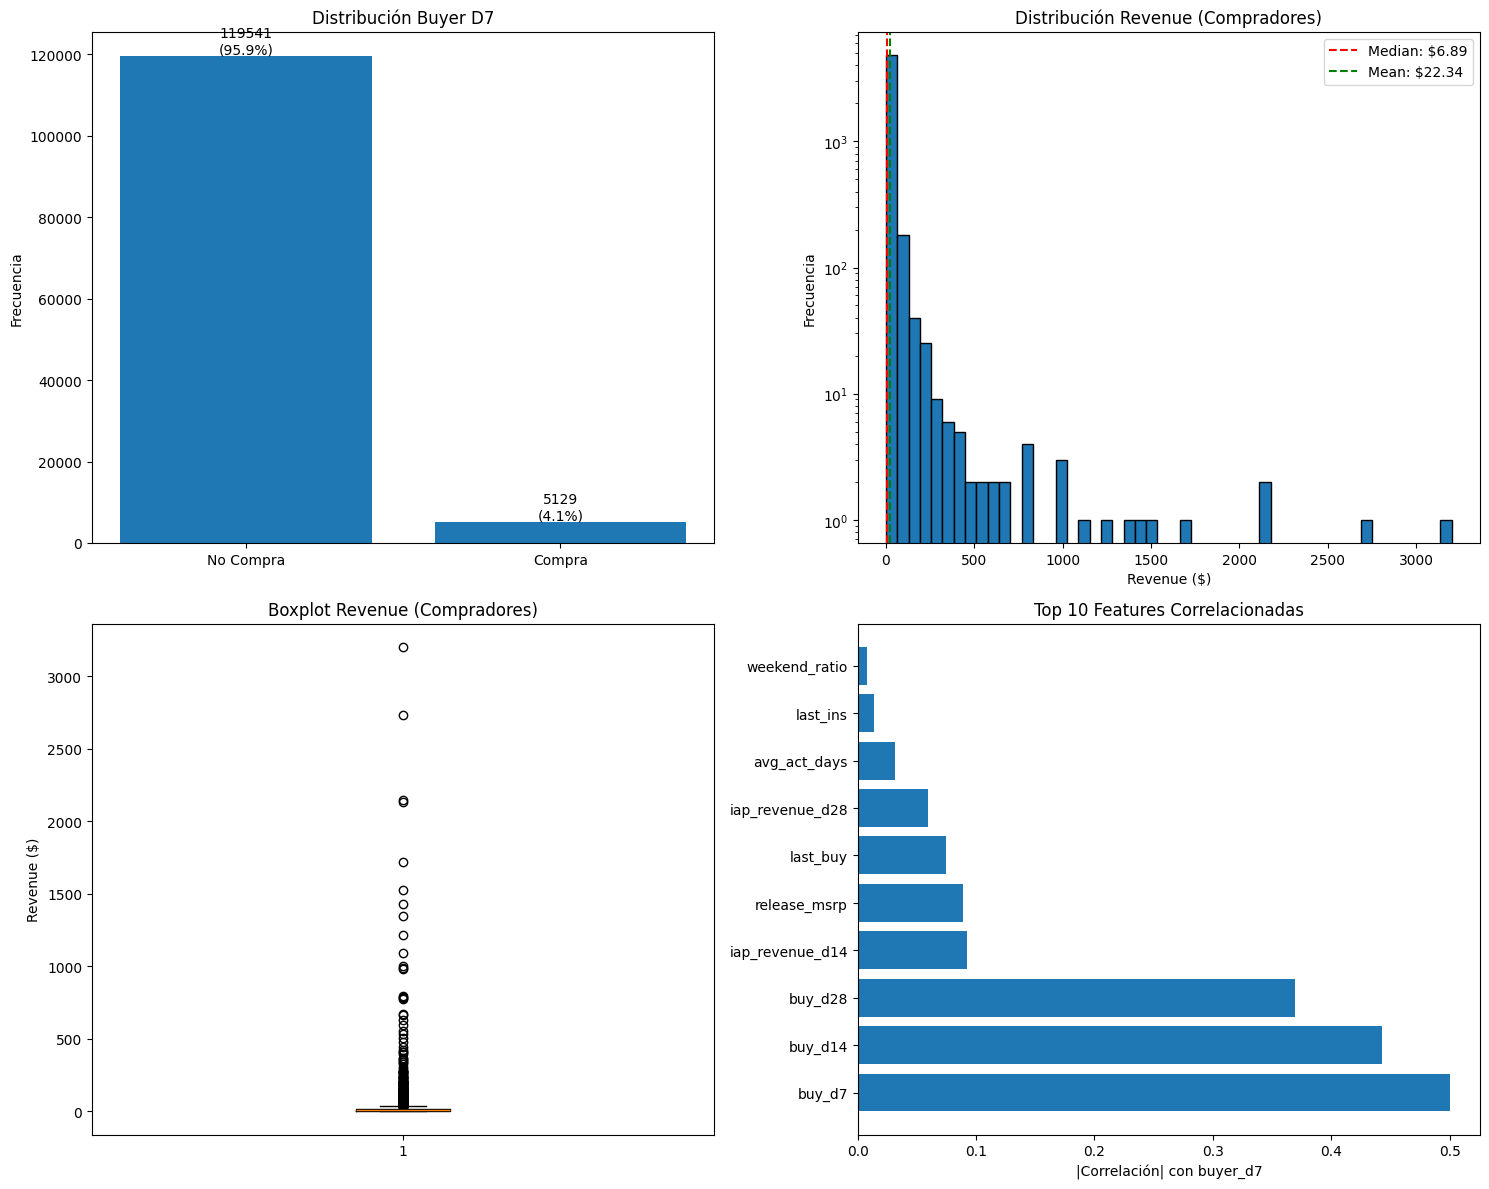


RESUMEN ESTRATÉGICO
✓ Desbalanceo: 23.3:1
✓ Revenue medio compradores: $22.34
✓ Revenue mediano compradores: $6.89
✓ Diferencia media-mediana: 224.3% (indica outliers)

RECOMENDACIÓN:
→ Usar enfoque de dos etapas
→ Predecir percentil 40-45 en vez de media para evitar sobreestimación
→ P40 = $4.87
→ P45 = $5.77


In [7]:

# 6. Visualizaciones
print("\n" + "=" * 50)
print("GENERANDO VISUALIZACIONES...")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribución buyer_d7
buyer_counts = ddf['buyer_d7'].value_counts().compute()
axes[0, 0].bar(['No Compra', 'Compra'], buyer_counts.values)
axes[0, 0].set_title('Distribución Buyer D7')
axes[0, 0].set_ylabel('Frecuencia')
for i, v in enumerate(buyer_counts.values):
    axes[0, 0].text(i, v, f'{v}\n({v/buyer_counts.sum()*100:.1f}%)', 
                    ha='center', va='bottom')

# Plot 2: Distribución revenue (log scale)
axes[0, 1].hist(buyers_revenue, bins=50, edgecolor='black')
axes[0, 1].set_title('Distribución Revenue (Compradores)')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_yscale('log')
axes[0, 1].axvline(buyers_revenue.median(), color='red', 
                   linestyle='--', label=f'Median: ${buyers_revenue.median():.2f}')
axes[0, 1].axvline(buyers_revenue.mean(), color='green', 
                   linestyle='--', label=f'Mean: ${buyers_revenue.mean():.2f}')
axes[0, 1].legend()

# Plot 3: Boxplot revenue
axes[1, 0].boxplot(buyers_revenue, vert=True)
axes[1, 0].set_title('Boxplot Revenue (Compradores)')
axes[1, 0].set_ylabel('Revenue ($)')

# Plot 4: Top correlaciones
if sorted_corr:
    top_features = [x[0] for x in sorted_corr[:10]]
    top_corrs = [x[1] for x in sorted_corr[:10]]
    axes[1, 1].barh(range(len(top_features)), top_corrs)
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features)
    axes[1, 1].set_xlabel('|Correlación| con buyer_d7')
    axes[1, 1].set_title('Top 10 Features Correlacionadas')

plt.tight_layout()
plt.savefig('exploratory_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualizaciones guardadas en 'exploratory_analysis.png'")

plt.show()

# 7. Resumen estratégico
print("\n" + "=" * 50)
print("RESUMEN ESTRATÉGICO")
print("=" * 50)
print(f"✓ Desbalanceo: {buyer_counts[0]/buyer_counts[1]:.1f}:1")
print(f"✓ Revenue medio compradores: ${buyers_revenue.mean():.2f}")
print(f"✓ Revenue mediano compradores: ${buyers_revenue.median():.2f}")
print(f"✓ Diferencia media-mediana: {(buyers_revenue.mean()/buyers_revenue.median() - 1)*100:.1f}% (indica outliers)")
print("\nRECOMENDACIÓN:")
print("→ Usar enfoque de dos etapas")
print("→ Predecir percentil 40-45 en vez de media para evitar sobreestimación")
print(f"→ P40 = ${buyers_revenue.quantile(0.40):.2f}")
print(f"→ P45 = ${buyers_revenue.quantile(0.45):.2f}")

In [8]:
# Método de percentiles - eliminar extremos
print("\n" + "=" * 50)
print("CLIPPING POR PERCENTILES")
print("=" * 50)

buyers_data = ddf[ddf['buyer_d7'] == 1].compute()

# Eliminar top 5% y bottom 1% (ajusta según necesites)
p99 = buyers_data['iap_revenue_d7'].quantile(0.99)

print(f"P95: ${p99:.2f}")

buyers_clean = buyers_data[
    (buyers_data['iap_revenue_d7'] <= p99)
]

print(f"\nDatos originales: {len(buyers_data)}")
print(f"Datos limpios: {len(buyers_clean)}")
print(f"Removidos: {len(buyers_data) - len(buyers_clean)} ({(len(buyers_data) - len(buyers_clean))/len(buyers_data)*100:.1f}%)")


CLIPPING POR PERCENTILES
P95: $227.14

Datos originales: 5129
Datos limpios: 5077
Removidos: 52 (1.0%)



VISUALIZACIÓN ANTES Y DESPUÉS DE LIMPIAR
✓ Gráficos guardados en 'outliers_comparison.png'


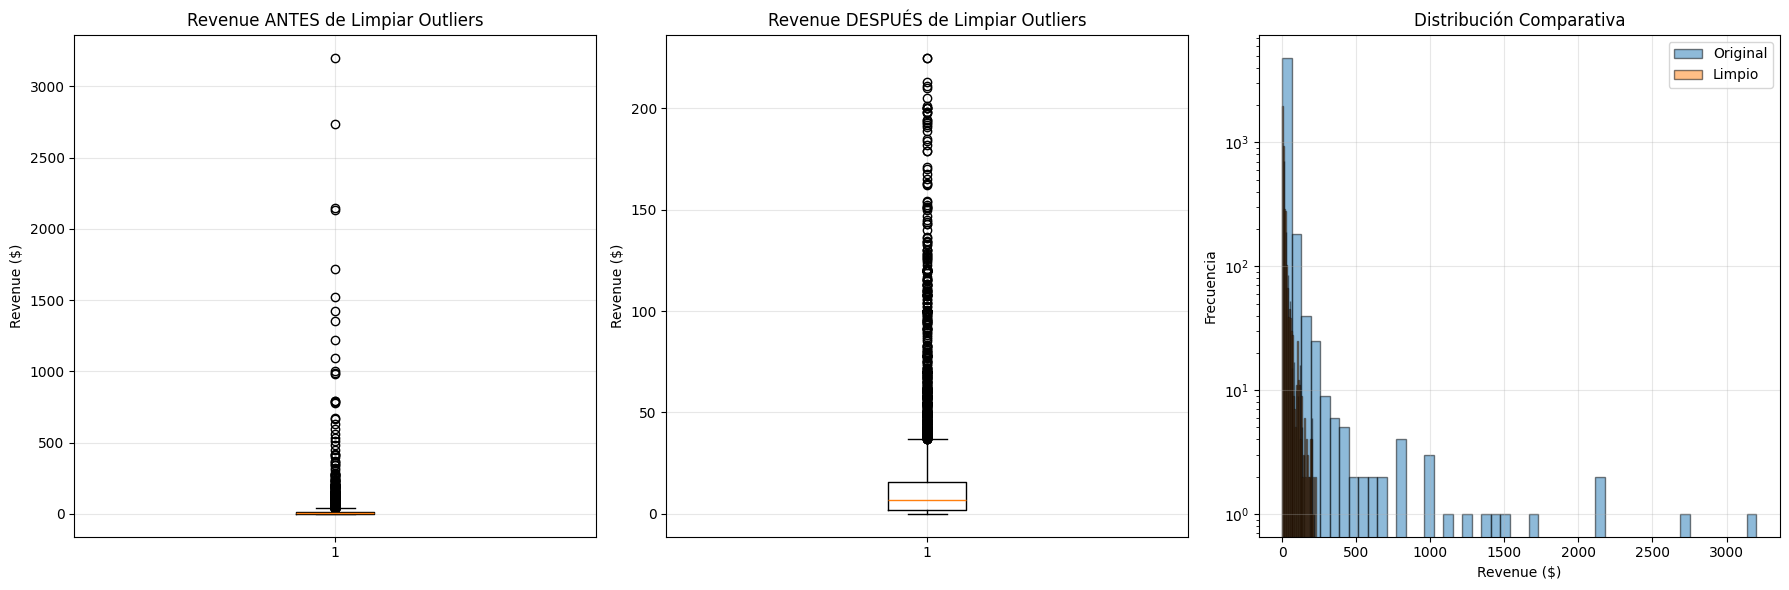


ESTADÍSTICAS COMPARATIVAS
Métrica                     Original          Limpio        Cambio %
----------------------------------------------------------------------
Mean                 $         22.34 $         15.16          -32.2%
Median               $          6.89 $          6.89            0.0%
Std Dev              $        100.29 $         26.04          -74.0%
Max                  $       3201.20 $        224.92          -93.0%

Observaciones                   5129            5077           -1.0%


In [9]:
# Visualización comparativa de outliers
print("\n" + "=" * 50)
print("VISUALIZACIÓN ANTES Y DESPUÉS DE LIMPIAR")
print("=" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Boxplot ANTES de limpiar
axes[0].boxplot(buyers_data['iap_revenue_d7'], vert=True)
axes[0].set_title('Revenue ANTES de Limpiar Outliers')
axes[0].set_ylabel('Revenue ($)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Boxplot DESPUÉS de limpiar
axes[1].boxplot(buyers_clean['iap_revenue_d7'], vert=True)
axes[1].set_title('Revenue DESPUÉS de Limpiar Outliers')
axes[1].set_ylabel('Revenue ($)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Histograma comparativo
axes[2].hist(buyers_data['iap_revenue_d7'], bins=50, alpha=0.5, label='Original', edgecolor='black')
axes[2].hist(buyers_clean['iap_revenue_d7'], bins=50, alpha=0.5, label='Limpio', edgecolor='black')
axes[2].set_title('Distribución Comparativa')
axes[2].set_xlabel('Revenue ($)')
axes[2].set_ylabel('Frecuencia')
axes[2].legend()
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outliers_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Gráficos guardados en 'outliers_comparison.png'")
plt.show()

# Estadísticas comparativas
print("\n" + "=" * 50)
print("ESTADÍSTICAS COMPARATIVAS")
print("=" * 50)
print(f"{'Métrica':<20} {'Original':>15} {'Limpio':>15} {'Cambio %':>15}")
print("-" * 70)

original_mean = buyers_data['iap_revenue_d7'].mean()
clean_mean = buyers_clean['iap_revenue_d7'].mean()
print(f"{'Mean':<20} ${original_mean:>14.2f} ${clean_mean:>14.2f} {((clean_mean/original_mean-1)*100):>14.1f}%")

original_median = buyers_data['iap_revenue_d7'].median()
clean_median = buyers_clean['iap_revenue_d7'].median()
print(f"{'Median':<20} ${original_median:>14.2f} ${clean_median:>14.2f} {((clean_median/original_median-1)*100):>14.1f}%")

original_std = buyers_data['iap_revenue_d7'].std()
clean_std = buyers_clean['iap_revenue_d7'].std()
print(f"{'Std Dev':<20} ${original_std:>14.2f} ${clean_std:>14.2f} {((clean_std/original_std-1)*100):>14.1f}%")

original_max = buyers_data['iap_revenue_d7'].max()
clean_max = buyers_clean['iap_revenue_d7'].max()
print(f"{'Max':<20} ${original_max:>14.2f} ${clean_max:>14.2f} {((clean_max/original_max-1)*100):>14.1f}%")

print(f"\n{'Observaciones':<20} {len(buyers_data):>15} {len(buyers_clean):>15} {((len(buyers_clean)/len(buyers_data)-1)*100):>14.1f}%")

In [10]:
numeric_cols = []
object_cols = []
category_cols = []

for col in cols:
    if ddf[col].dtype in ['int32', 'int64', 'float64']:
        numeric_cols.append(col)
    elif ddf[col].dtype == 'object':
        object_cols.append(col)
    else:
        category_cols.append(col)
        
print(f"Numeric cols: {numeric_cols}")
print(f"Object cols: {object_cols}")
print(f"Category cols: {category_cols}")


Numeric cols: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'release_msrp', 'weekday', 'avg_act_days', 'avg_days_ins', 'first_request_ts', 'last_buy', 'last_ins', 'weekend_ratio', 'weeks_since_first_seen', 'wifi_ratio']
Object cols: ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'release_date', 'avg_daily_sessions', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'city_hist', 'country_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'dev_language_hist', 'dev_osv_hist', 'first_request_ts_bundle', 'first_request_ts_category_bottom_taxonomy', 'hour_ratio', 'iap_reven

In [11]:
# 1. INGENIERÍA DE FEATURES (más importante que imputación)
print("=" * 50)
print("FEATURE ENGINEERING")
print("=" * 50)

# Crear features útiles
# Ratios y proporciones
ddf['retention_ratio'] = ddf['retention_d7_to_d14'] / (ddf['retention_d1_to_d7'] + 1e-10)
ddf['days_active_ratio'] = ddf['avg_act_days'] / (ddf['weeks_since_first_seen'] * 7 + 1e-10)

# Flags de comportamiento
ddf['is_weekend_user'] = (ddf['weekend_ratio'] > 0.5).astype(int)
ddf['is_wifi_user'] = (ddf['wifi_ratio'] > 0.7).astype(int)
ddf['has_previous_purchase'] = (ddf['last_buy'] > 0).astype(int)

# Interacciones
ddf['retention_x_registration'] = ddf['retention_d1'] * ddf['registration']

print("✓ Features creadas")

FEATURE ENGINEERING
✓ Features creadas


In [12]:
# 2. ENCODING DE VARIABLES CATEGÓRICAS (VERSIÓN MEJORADA CON MISSING)
print("\n" + "=" * 50)
print("ENCODING CATEGORICAS")
print("=" * 50)

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Para Dask, necesitas computar primero
df_sample = ddf.compute()

# Label Encoding para columnas categóricas
label_encoders = {}
for col in object_cols:
    if col in df_sample.columns:
        # Manejar nulos antes de encodear
        df_sample[col] = df_sample[col].fillna('MISSING')
        df_sample[col] = df_sample[col].astype(str)
        
        # OBTENER VALORES ÚNICOS Y AÑADIR 'MISSING' SI NO ESTÁ
        unique_values = df_sample[col].unique().tolist()
        if 'MISSING' not in unique_values:
            unique_values.append('MISSING')
        
        # Encodear usando todos los valores únicos (incluido 'MISSING')
        le = LabelEncoder()
        le.fit(unique_values)  # ← FIT CON TODOS LOS VALORES INCLUYENDO 'MISSING'
        
        df_sample[col + '_encoded'] = le.transform(df_sample[col])
        label_encoders[col] = le
        
        print(f"✓ Encoded: {col} ({len(unique_values)} categorías, incluye MISSING)")

# Eliminar columnas originales object
df_sample = df_sample.drop(columns=object_cols)

print(f"\n✓ Total columnas encodeadas: {len(label_encoders)}")
print(f"✓ Shape final: {df_sample.shape}")


ENCODING CATEGORICAS
✓ Encoded: advertiser_bundle (429 categorías, incluye MISSING)
✓ Encoded: advertiser_category (22 categorías, incluye MISSING)
✓ Encoded: advertiser_subcategory (57 categorías, incluye MISSING)
✓ Encoded: advertiser_bottom_taxonomy_level (86 categorías, incluye MISSING)
✓ Encoded: carrier (3951 categorías, incluye MISSING)
✓ Encoded: country (207 categorías, incluye MISSING)
✓ Encoded: region (1129 categorías, incluye MISSING)
✓ Encoded: dev_make (210 categorías, incluye MISSING)
✓ Encoded: dev_model (4863 categorías, incluye MISSING)
✓ Encoded: dev_os (3 categorías, incluye MISSING)
✓ Encoded: dev_osv (162 categorías, incluye MISSING)
✓ Encoded: hour (2 categorías, incluye MISSING)
✓ Encoded: release_date (174 categorías, incluye MISSING)
✓ Encoded: avg_daily_sessions (22163 categorías, incluye MISSING)
✓ Encoded: avg_duration (31050 categorías, incluye MISSING)
✓ Encoded: bcat (54371 categorías, incluye MISSING)
✓ Encoded: bcat_bottom_taxonomy (54330 categorías,

/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])
/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: num_buys_category_bottom_taxonomy (1401 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: region_hist (60588 categorías, incluye MISSING)
✓ Encoded: rev_by_adv (2169 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])
/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: rwd_prank (56138 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: user_bundles (49066 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: user_bundles_l28d (62410 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: whale_users_bundle_num_buys_prank (2870 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: whale_users_bundle_revenue_prank (4582 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: whale_users_bundle_total_num_buys (2440 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: whale_users_bundle_total_revenue (4502 categorías, incluye MISSING)


/tmp/ipykernel_42334/3952777514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sample[col + '_encoded'] = le.transform(df_sample[col])


✓ Encoded: row_id (124671 categorías, incluye MISSING)

✓ Total columnas encodeadas: 57
✓ Shape final: (124670, 91)


In [13]:
# VERIFICAR TIPOS DE DATOS
print("\n" + "=" * 50)
print("VERIFICACIÓN FINAL")
print("=" * 50)
df_sample = df_sample.drop(columns='datetime')

# Ver tipos de datos finales
print("\nTipos de datos:")
print(df_sample.dtypes.value_counts())

# Verificar nulos
null_counts = df_sample.isnull().sum()
if null_counts.sum() > 0:
    print("\n⚠ Columnas con nulos:")
    print(null_counts[null_counts > 0])
else:
    print("\n✓ No hay valores nulos")

# Verificar que todas las columnas son numéricas
non_numeric = df_sample.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns.tolist()
if non_numeric:
    print(f"\n⚠ Columnas no numéricas detectadas: {non_numeric}")
else:
    print("\n✓ Todas las columnas son numéricas")


VERIFICACIÓN FINAL

Tipos de datos:
int64      63
float64    22
int32       5
Name: count, dtype: int64

⚠ Columnas con nulos:
registration                 64703
retention_d1_to_d7           11662
retention_d3_to_d7           11662
retention_d7_to_d14          11662
retention_d1                 11662
retention_d3                 11662
retentiond7                  11662
release_msrp                 13167
avg_act_days                 55282
avg_days_ins                116231
first_request_ts             69128
last_buy                    121939
last_ins                    103317
weekend_ratio                53020
weeks_since_first_seen       52750
wifi_ratio                   53032
retention_ratio              11662
days_active_ratio            55282
retention_x_registration     68398
dtype: int64

✓ Todas las columnas son numéricas


In [14]:
# 3. PREPARAR DATOS PARA XGBOOST
print("\n" + "=" * 50)
print("PREPARACIÓN PARA XGBOOST")
print("=" * 50)

# Separar features y targets
feature_cols = [col for col in df_sample.columns 
                if col not in ['buyer_d7', 'iap_revenue_d7', 'buyer_d1', 'buyer_d14', 
                               'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28',
                               'iap_revenue_d14', 'iap_revenue_d28']]

X = df_sample[feature_cols]
y_buyer = df_sample['buyer_d7']
y_revenue = df_sample['iap_revenue_d7']

print(f"Features: {len(feature_cols)}")
print(f"Filas: {len(X)}")
print(f"Nulos en X: {X.isnull().sum().sum()}")
print("\n✓ NO HACE FALTA IMPUTAR - XGBoost lo maneja")


PREPARACIÓN PARA XGBOOST
Features: 80
Filas: 124670
Nulos en X: 907883

✓ NO HACE FALTA IMPUTAR - XGBoost lo maneja


In [15]:

import numpy as np
# 4. MODELO XGBOOST - Dos etapas
print("\n" + "=" * 50)
print("ENTRENAMIENTO XGBOOST")
print("=" * 50)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error

# Split train/test
X_train, X_test, y_buyer_train, y_buyer_test, y_rev_train, y_rev_test = train_test_split(
    X, y_buyer, y_revenue, test_size=0.2, random_state=42, stratify=y_buyer
)

# ETAPA 1: Predecir si compra (clasificación)
print("\n--- ETAPA 1: Clasificación (Buyer) ---")
model_buyer = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=(y_buyer_train == 0).sum() / (y_buyer_train == 1).sum(),  # Para desbalanceo
    random_state=42,
    tree_method='hist',
    enable_categorical=True
)

model_buyer.fit(X_train, y_buyer_train)
y_buyer_pred = model_buyer.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_buyer_test, y_buyer_pred)
print(f"✓ AUC: {auc:.4f}")

# ETAPA 2: Predecir revenue (solo para compradores)
print("\n--- ETAPA 2: Regresión (Revenue) ---")
X_train_buyers = X_train[y_buyer_train == 1]
y_rev_train_buyers = y_rev_train[y_buyer_train == 1]

model_revenue = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=150,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)

X_train_buyers.dtypes.value_counts()
model_revenue.fit(X_train_buyers, y_rev_train_buyers)

# Predecir solo para los que el modelo de clasificación predijo como compradores
buyer_threshold = 0.3  # Ajustar según necesidad
predicted_buyers = y_buyer_pred > buyer_threshold
y_rev_pred = np.zeros(len(X_test))
y_rev_pred[predicted_buyers] = model_revenue.predict(X_test[predicted_buyers])

rmse = mean_squared_error(y_rev_test, y_rev_pred)
print(f"✓ RMSE: ${rmse:.2f}")


ENTRENAMIENTO XGBOOST

--- ETAPA 1: Clasificación (Buyer) ---
✓ AUC: 0.9302

--- ETAPA 2: Regresión (Revenue) ---
✓ RMSE: $811.39


In [16]:
# ANÁLISIS DE PREDICCIONES
print("\n" + "=" * 50)
print("ANÁLISIS DE PREDICCIONES")
print("=" * 50)

# 1. Ver primeras predicciones
import pandas as pd

results_df = pd.DataFrame({
    'buyer_real': y_buyer_test.values,
    'buyer_pred_proba': y_buyer_pred,
    'buyer_pred_class': (y_buyer_pred > buyer_threshold).astype(int),
    'revenue_real': y_rev_test.values,
    'revenue_pred': y_rev_pred
})

print("\nPrimeras 20 predicciones:")
print(results_df.head(20).to_string(index=False))

# 2. Estadísticas de las predicciones
print("\n" + "=" * 50)
print("ESTADÍSTICAS PREDICCIONES")
print("=" * 50)

print(f"\n{'Métrica':<25} {'Real':>15} {'Predicho':>15}")
print("-" * 60)
print(f"{'Buyer rate (%)':<25} {y_buyer_test.mean()*100:>14.2f}% {(y_buyer_pred > buyer_threshold).mean()*100:>14.2f}%")
print(f"{'Revenue medio ($)':<25} ${y_rev_test.mean():>14.2f} ${y_rev_pred.mean():>14.2f}")
print(f"{'Revenue mediano ($)':<25} ${y_rev_test.median():>14.2f} ${np.median(y_rev_pred):>14.2f}")
print(f"{'Revenue total ($)':<25} ${y_rev_test.sum():>14.2f} ${y_rev_pred.sum():>14.2f}")
print(f"{'Max revenue ($)':<25} ${y_rev_test.max():>14.2f} ${y_rev_pred.max():>14.2f}")

# 3. Análisis solo de compradores reales
print("\n" + "=" * 50)
print("PREDICCIONES EN COMPRADORES REALES")
print("=" * 50)

real_buyers = y_buyer_test == 1
if real_buyers.sum() > 0:
    print(f"\nCompradores reales: {real_buyers.sum()}")
    print(f"Detectados por modelo: {((y_buyer_pred > buyer_threshold) & real_buyers).sum()}")
    print(f"Tasa de detección: {((y_buyer_pred > buyer_threshold) & real_buyers).sum() / real_buyers.sum() * 100:.1f}%")
    
    print(f"\nRevenue real (compradores): ${y_rev_test[real_buyers].mean():.2f}")
    print(f"Revenue pred (compradores): ${y_rev_pred[real_buyers].mean():.2f}")

# 4. Distribución de probabilidades de compra
print("\n" + "=" * 50)
print("DISTRIBUCIÓN PROBABILIDADES")
print("=" * 50)

print(f"P10: {np.percentile(y_buyer_pred, 10):.4f}")
print(f"P25: {np.percentile(y_buyer_pred, 25):.4f}")
print(f"P50: {np.percentile(y_buyer_pred, 50):.4f}")
print(f"P75: {np.percentile(y_buyer_pred, 75):.4f}")
print(f"P90: {np.percentile(y_buyer_pred, 90):.4f}")
print(f"P95: {np.percentile(y_buyer_pred, 95):.4f}")
print(f"P99: {np.percentile(y_buyer_pred, 99):.4f}")


ANÁLISIS DE PREDICCIONES

Primeras 20 predicciones:
 buyer_real  buyer_pred_proba  buyer_pred_class  revenue_real  revenue_pred
          0          0.017330                 0      0.000000      0.000000
          0          0.001540                 0      0.000000      0.000000
          0          0.277282                 0      0.000000      0.000000
          0          0.018792                 0      0.000000      0.000000
          1          0.896271                 1    422.790000     18.092621
          0          0.406415                 1      0.000000     17.073807
          0          0.462567                 1      0.000000     21.819635
          0          0.181104                 0      0.000000      0.000000
          0          0.137443                 0      0.000000      0.000000
          0          0.035509                 0      0.000000      0.000000
          0          0.101078                 0      0.000000      0.000000
          0          0.725802      

In [17]:
# VERIFICAR COLUMNAS DEL TEST SET
print("\n" + "=" * 80)
print("VERIFICANDO COLUMNAS DEL TEST SET")
print("=" * 80)

import dask.dataframe as dd

test_path = "./smadex-challenge-predict-the-revenue/test/test"
ddf_test = dd.read_parquet(test_path)

# Ver columnas disponibles
test_cols = ddf_test.columns.tolist()
train_cols = ddf.columns.tolist()

print(f"\nColumnas en TEST: {len(test_cols)}")
print(f"Columnas en TRAIN: {len(train_cols)}")

# Columnas que están en train pero NO en test
missing_in_test = set(train_cols) - set(test_cols)
print(f"\n⚠ Columnas en TRAIN pero NO en TEST ({len(missing_in_test)}):")
for col in sorted(missing_in_test):
    print(f"  - {col}")

# Columnas que están en test pero NO en train
extra_in_test = set(test_cols) - set(train_cols)
print(f"\n✓ Columnas en TEST pero NO en TRAIN ({len(extra_in_test)}):")
for col in sorted(extra_in_test):
    print(f"  - {col}")

# Ver tipos de datos en test
print("\nTipos de datos en TEST:")
print(ddf_test.dtypes)


VERIFICANDO COLUMNAS DEL TEST SET

Columnas en TEST: 68
Columnas en TRAIN: 91

⚠ Columnas en TRAIN pero NO en TEST (23):
  - buy_d14
  - buy_d28
  - buy_d7
  - buyer_d1
  - buyer_d14
  - buyer_d28
  - buyer_d7
  - days_active_ratio
  - has_previous_purchase
  - iap_revenue_d14
  - iap_revenue_d28
  - iap_revenue_d7
  - is_weekend_user
  - is_wifi_user
  - registration
  - retention_d1
  - retention_d1_to_d7
  - retention_d3
  - retention_d3_to_d7
  - retention_d7_to_d14
  - retention_ratio
  - retention_x_registration
  - retentiond7

✓ Columnas en TEST pero NO en TRAIN (0):

Tipos de datos en TEST:
advertiser_bundle                               object
advertiser_category                             object
advertiser_subcategory                          object
advertiser_bottom_taxonomy_level                object
carrier                                         object
country                                         object
region                                          object
dev_mak

In [ ]:
# GENERAR PREDICCIONES PARA TEST CON DASK (OPTIMIZADO PARA MEMORIA)
print("\n" + "=" * 80)
print("GENERANDO PREDICCIONES PARA TEST SET (PROCESAMIENTO POR FRAGMENTOS)")
print("=" * 80)

import dask.dataframe as dd
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. CARGAR DATOS DE TEST (LAZY - NO CARGA EN MEMORIA)
print("\n[1/7] Cargando datos de test (lazy)...")
test_path = "./smadex-challenge-predict-the-revenue/test/test"
ddf_test = dd.read_parquet(test_path)

n_partitions = ddf_test.npartitions
print(f"✓ Dataset tiene {n_partitions} particiones")
print(f"✓ Procesaremos de forma lazy para ahorrar memoria")

# 2. FUNCIÓN PARA PROCESAR UNA PARTICIÓN (CORREGIDA)
def process_partition(df_partition, label_encoders, object_cols, feature_cols):
    """Procesa una partición aplicando feature engineering y encoding"""
    
    # Guardar row_ids
    partition_row_ids = df_partition.index.values
    
    # Feature Engineering
    test_columns = set(df_partition.columns)
    
    if 'retention_d7_to_d14' in test_columns and 'retention_d1_to_d7' in test_columns:
        df_partition['retention_ratio'] = df_partition['retention_d7_to_d14'] / (df_partition['retention_d1_to_d7'] + 1e-10)
    
    if 'avg_act_days' in test_columns and 'weeks_since_first_seen' in test_columns:
        df_partition['days_active_ratio'] = df_partition['avg_act_days'] / (df_partition['weeks_since_first_seen'] * 7 + 1e-10)
    
    if 'weekend_ratio' in test_columns:
        df_partition['is_weekend_user'] = (df_partition['weekend_ratio'] > 0.5).astype(int)
    
    if 'wifi_ratio' in test_columns:
        df_partition['is_wifi_user'] = (df_partition['wifi_ratio'] > 0.7).astype(int)
    
    if 'last_buy' in test_columns:
        df_partition['has_previous_purchase'] = (df_partition['last_buy'] > 0).astype(int)
    
    if 'retention_d1' in test_columns and 'registration' in test_columns:
        df_partition['retention_x_registration'] = df_partition['retention_d1'] * df_partition['registration']
    
    # Encoding categóricas (CORREGIDO)
    for col in object_cols:
        if col in df_partition.columns and col in label_encoders:
            # Rellenar nulos
            df_partition[col] = df_partition[col].fillna('MISSING')
            df_partition[col] = df_partition[col].astype(str)
            
            le = label_encoders[col]
            known_categories = set(le.classes_)
            
            # SOLUCIÓN: Asignar un código específico a valores desconocidos
            # Usar -1 para categorías desconocidas (XGBoost lo maneja bien)
            def safe_encode(value):
                if value in known_categories:
                    return le.transform([value])[0]
                else:
                    return -1  # Código para valores desconocidos
            
            df_partition[col + '_encoded'] = df_partition[col].apply(safe_encode)
    
    # Eliminar columnas object
    df_partition = df_partition.drop(columns=[col for col in object_cols if col in df_partition.columns])
    
    # Eliminar datetime si existe
    if 'datetime' in df_partition.columns:
        df_partition = df_partition.drop(columns=['datetime'])
    
    # Asegurar que tenemos todas las features (rellenar con 0 si faltan)
    for feat in feature_cols:
        if feat not in df_partition.columns:
            df_partition[feat] = 0
    
    # Seleccionar solo las features necesarias
    X_partition = df_partition[feature_cols]
    
    return partition_row_ids, X_partition

# 3. PROCESAR PARTICIONES Y PREDECIR
print("\n[2/7] Procesando particiones y generando predicciones...")

all_row_ids = []
all_predictions = []

# Procesar cada partición individualmente
for i in tqdm(range(n_partitions), desc="Procesando particiones"):
    # Obtener una partición
    partition_ddf = ddf_test.get_partition(i)
    df_partition = partition_ddf.compute()
    
    # Procesar partición
    partition_row_ids, X_partition = process_partition(
        df_partition, label_encoders, object_cols, feature_cols
    )
    
    # Predecir
    buyer_probs = model_buyer.predict_proba(X_partition)[:, 1]
    predicted_buyers_mask = buyer_probs > 0.3
    
    revenue_predictions = np.zeros(len(X_partition))
    if predicted_buyers_mask.sum() > 0:
        revenue_predictions[predicted_buyers_mask] = model_revenue.predict(
            X_partition[predicted_buyers_mask]
        )
    
    revenue_predictions = np.maximum(revenue_predictions, 0)
    
    # Guardar resultados
    all_row_ids.extend(partition_row_ids)
    all_predictions.extend(revenue_predictions)
    
    # Liberar memoria
    del df_partition, X_partition, buyer_probs, predicted_buyers_mask, revenue_predictions
    import gc
    gc.collect()

print(f"\n✓ Procesadas {n_partitions} particiones")
print(f"✓ Total predicciones: {len(all_predictions):,}")

# 4. CREAR SUBMISSION
print("\n[3/7] Creando archivo de submission...")

submission_df = pd.DataFrame({
    'row_id': all_row_ids,
    'iap_revenue_d7': all_predictions
})

# Guardar CSV
submission_df.to_csv('submission.csv', index=False)

# 5. ESTADÍSTICAS
print("\n" + "=" * 80)
print("✓ SUBMISSION GENERADO EXITOSAMENTE")
print("=" * 80)
print(f"\nArchivo: submission.csv")
print(f"Registros: {len(submission_df):,}")

print(f"\nPrimeras 10 predicciones:")
print(submission_df.head(10).to_string(index=False))

print(f"\nEstadísticas finales:")
print(f"  • Predicciones = 0: {(submission_df['iap_revenue_d7'] == 0).sum():,} ({(submission_df['iap_revenue_d7'] == 0).mean()*100:.1f}%)")
print(f"  • Predicciones > 0: {(submission_df['iap_revenue_d7'] > 0).sum():,} ({(submission_df['iap_revenue_d7'] > 0).mean()*100:.1f}%)")
print(f"  • Revenue medio: ${submission_df['iap_revenue_d7'].mean():.2f}")
print(f"  • Revenue mediano: ${submission_df['iap_revenue_d7'].median():.2f}")
print(f"  • Revenue máximo: ${submission_df['iap_revenue_d7'].max():.2f}")
print(f"  • Revenue total: ${submission_df['iap_revenue_d7'].sum():,.2f}")

# Verificar formato
print(f"\n✓ Formato verificado:")
print(f"  • Columnas correctas: {list(submission_df.columns) == ['row_id', 'iap_revenue_d7']}")
print(f"  • Sin valores nulos: {submission_df.isnull().sum().sum() == 0}")
print(f"  • Row IDs únicos: {submission_df['row_id'].nunique() == len(submission_df)}")

print("\n🎉 ¡Listo para subir a Kaggle!")


GENERANDO PREDICCIONES PARA TEST SET (PROCESAMIENTO POR FRAGMENTOS)

[1/7] Cargando datos de test (lazy)...
✓ Dataset tiene 96 particiones
✓ Procesaremos de forma lazy para ahorrar memoria

[2/7] Procesando particiones y generando predicciones...


Procesando particiones:   0%|          | 0/96 [00:00<?, ?it/s]